# Pinball

In [1]:
#IMPORT LIBRARIES

from dolfin import *
from math import log, exp
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from IPython.display import clear_output as clc
from IPython.display import display
import time

from dlroms.cores import CPU # For swapping cores
import dlroms.fespaces as fe # Handles finite element spaces
import dlroms.geometry as geo # Mesh creation
from dlroms.roms import num2p # Percentage format

import seaborn as sns
teal = sns.light_palette("teal", 15)
magenta = sns.dark_palette("magenta", 15)
red = sns.light_palette("orangered", 15)
navy = sns.light_palette("navy", 15)

set_log_level(LogLevel.ERROR)

# State problem

Fokker-Planck equation
\begin{cases}
     \dfrac{\partial y}{\partial t} + \nabla \cdot (- \nu \nabla y + \mathbf{u} y + \mathbf{v} y) = 0 \qquad &\mathrm{in} \ \Omega \times (0,T)  \\
             (-\nu \nabla y + \mathbf{u} y + \mathbf{v} y) \cdot \mathbf{n} = 0  \qquad &\mathrm{on} \ \partial \Omega  \times (0,T) \\
       y(0) = \bar{y} \qquad &\mathrm{in} \ \Omega \times \{t = 0\}
\end{cases}


where $\Omega$ is the domain of interest (visualised below) with boundary $\partial \Omega$, $T>0$ is the final time, $y: \Omega \times [0,T] \to \mathbb R$ is the unknown state field, $\mathbf{u}:\Omega times [0,T) \to \mathbb R^2$ is the control velocity field, $\mathbf{v}:\Omega \to \mathbb R^2$ is the fluid flow velocity field computed via steady Navier-Stokes, $\nu$ is the diffusion coefficient, $\mathbf{n}$ is the normal versor and $\bar{y}$ is the initial datum

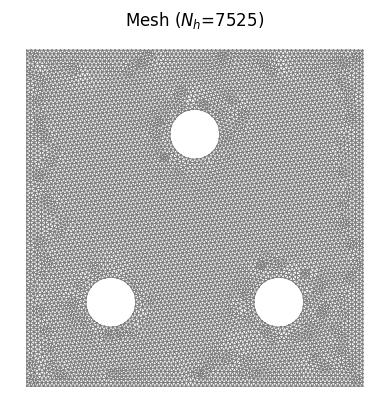

In [2]:
# CREATE THE MESH FOR THE STATE PROBLEM

domain = geo.Rectangle((-1.0, -1.0), (1.0, 1.0)) - geo.Circle((-0.5, -0.5), 0.15) - geo.Circle((0.5, -0.5), 0.15) - geo.Circle((0.0, 0.5), 0.15)
h = 0.05
mesh = geo.mesh(domain, stepsize = h)
mesh = refine(mesh)

plot(mesh, color = "grey", linewidth = 0.75)
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices())
plt.axis("off");

In [3]:
# DEFINE MEASURES

dx = Measure("dx", domain = mesh)

class GammaOBS1(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt((x[0] + 0.5)*(x[0] + 0.5) + (x[1] + 0.5)*(x[1] + 0.5))
        return on_boundary and d <= 0.15 + DOLFIN_EPS
class GammaOBS2(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt((x[0] - 0.5)*(x[0] - 0.5) + (x[1] + 0.5)*(x[1] + 0.5))
        return on_boundary and d <= 0.15 + DOLFIN_EPS
class GammaOBS3(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt(x[0]*x[0] + (x[1] - 0.5)*(x[1] - 0.5))
        return on_boundary and d <= 0.15 + DOLFIN_EPS
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
GammaOBS1().mark(boundaries, 1)
GammaOBS2().mark(boundaries, 2)
GammaOBS3().mark(boundaries, 3)

ds = Measure("ds", domain = mesh, subdomain_data = boundaries)

In [4]:
# DEFINE THE STATE SPACE

Yh = FunctionSpace(mesh, "CG", 1)
nstate = Yh.dim()

In [5]:
# DEFINE THE FLUID FLOW VELOCITY AND PRESSURE SPACES

Vh = VectorElement('CG', mesh.ufl_cell(), 2)
Ph = FiniteElement('CG', mesh.ufl_cell(), 1)
VPh = FunctionSpace(mesh, Vh * Ph)
Vh = VPh.sub(0).collapse()
Ph = VPh.sub(1).collapse()

nvelocity = Vh.dim()
npressure = Ph.dim()

In [6]:
# DEFINE THE STATE PROBLEM SOLVER

diffusion = 0.001
mu = 1.0
eps = 1e-8

def gaussian_generator(params):
    """
    Generate a 2D Gaussian starting from the mean position
    Input: mean coordinate
    Output: 2D Gaussian function
    """
    y0 = Expression('10 / pi * exp(- 10*(x[0] - x0)*(x[0] - x0) - 10*(x[1] - x1)*(x[1] - x1))', degree = 1, x0 = params[0], x1 = params[1])
    return interpolate(y0, Yh)

def compute_velocity(params):
    """
    Compute steady Navier-Stokes velocity via Newton method
    Input: inflow velocity parameters
    Output: steady Navier-Stokes velocity
    """
    
    n = FacetNormal(mesh)
    t = as_vector([n[1], -n[0]])

    # Free-slip BC on the wall
    wall = DirichletBC(VPh.sub(0), (0.0, 0.0), "on_boundary && (x[0] >= 0.9 || x[0] < -0.9 || x[1] < -0.9 || x[1] > 0.9)")

    # Solve state equation
    w, q = TestFunctions(VPh)
    vp = Function(VPh)
    v, p = split(vp)

    F = mu * inner(grad(v), grad(w)) * dx + dot(dot(grad(v), v), w) * dx - p * div(w) * dx - q * div(v) * dx + 1 / eps * inner(v, n) * inner(w, n) * (ds(1) + ds(2) + ds(3)) - 1 / eps * inner(v, t) * inner(w, t) * (ds(1) + ds(2) + ds(3)) + 1 / eps * params[0] * inner(w, t) * ds(1) + 1 / eps * params[1] * inner(w, t) * ds(2) + 1 / eps * params[2] * inner(w, t) * ds(3)
    solve(F == 0, vp, wall)
    v, p = vp.split(deepcopy=True)

    return v

def compute_state(v, y0, dt, ntimesteps):
    """
    Compute the state trajectory
    Input: initial condition, time step and number of timesteps
    Output: time-dependent solution of the Fokker-Planck equation
    """
   
    mod_in = project(v[1], Yh)(0,-1)

    yt = CPU.zeros(ntimesteps + 1, nstate)
    yt[0] = CPU.tensor(y0.vector())

    i = 0

    for i in range(ntimesteps):
           
        w = TestFunction(Yh)
        y = TrialFunction(Yh)

        a = inner(y, w) * dx + 0.5 * dt * (diffusion + mod_in * h / 2) * inner(grad(y), grad(w)) * dx - 0.5 * dt * y * project(v[0], Yh) * w.dx(0) * dx - 0.5 * dt * y * project(v[1], Yh) * w.dx(1) * dx
        L = inner(y0, w) * dx - 0.5 * dt * (diffusion + mod_in * h / 2) * inner(grad(y0), grad(w)) * dx + 0.5 * dt * y0 * project(v[0], Yh) * w.dx(0) * dx + 0.5 * dt * y0 * project(v[1], Yh) * w.dx(1) * dx
    
        y = Function(Yh)
        solve(a == L, y, DirichletBC(Yh, 0.0, "on_boundary"))
        
        y0.assign(y)
        yt[i+1] = CPU.tensor(y.vector())
             
    return yt

In [7]:
# SOLVE THE STATE PROBLEM

dt = Constant(0.1)
T = 5.0
ntimesteps = round(T / dt)

params = [0.5, 0.5, 1.0]
v = compute_velocity(params)

y0 = gaussian_generator([0.0, 0.0])

yt = compute_state(v, y0, dt, ntimesteps)
clc()

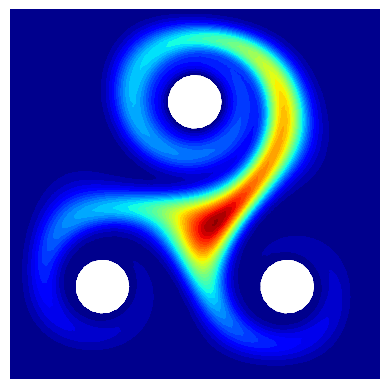

In [8]:
# TRAJECTORY (PLOT)

def trajectory(yt):
    for i in range(yt.shape[0]):
        fe.plot(yt[i], Yh, cmap = "jet", levelcurves = True)
        display(plt.gcf())
        plt.close()
        clc(wait=True)

trajectory(yt)

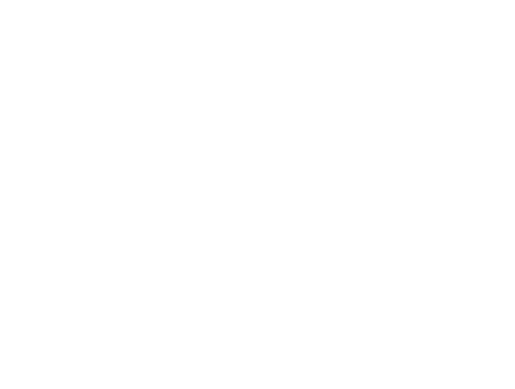

In [9]:
# TRAJECTORY WITH VELOCITY (PLOT) 

from matplotlib import colors

mesh_plot = geo.mesh(domain, stepsize = 0.2)

Vh_plot = VectorElement('CG', mesh_plot.ufl_cell(), 1)
Vh_plot = FunctionSpace(mesh_plot, Vh_plot)

clc()

white = colors.LinearSegmentedColormap.from_list("", ["white", "white"])

def plot_trajectory_with_velocity(yt, params, scale = None, colorbar = True, vmin = None, vmax = None, shrink = 1, format = "%0.2f"):
    """
    State trajectory with velocity gif
    Input: state and velocity parameters
    """

    v = compute_velocity(params)
    v.set_allow_extrapolation(True)
    for i in range(yt.shape[0]):
        fe.plot(yt[i], Yh, cmap = "jet", levelcurves = True, vmin = vmin, vmax = vmax, colorbar = colorbar, shrink = shrink, format = format)
        plot(project(v, Vh_plot), cmap = white, alpha = 0.6, scale = scale)
        display(plt.gcf())
        plt.close()
        plt.axis("off")
        clc(wait=True)

plot_trajectory_with_velocity(yt, params, scale = 10)

# Snapshots generation

In [ ]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

dt = Constant(0.1)
T = 5.0
ntimesteps = round(T / dt)
ntimes = ntimesteps + 1 # Time series length

ntrajectories = 500
ntrain = round(0.8 * ntrajectories)
ntrain *= ntimes
nsnapshots = ntrajectories * ntimes
nparams = 3

params_range = [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0)]

filename = 'Data/Pinball'
Y = CPU.zeros(ntrajectories, ntimes, nstate)
MU = CPU.zeros(ntrajectories, ntimes, nparams)

for i in range(ntrajectories):

    print(f"Generating snapshots n.{i}...")
    
    params = [0] * len(params_range)
    for j in range(len(params_range)):
        params[j] = ((params_range[j][1] - params_range[j][0]) * CPU.rand() + params_range[j][0]).item()  
    
    v = compute_velocity(params)
    
    y0 = gaussian_generator([0.0, 0.0])

    yt = compute_state(v, y0, dt, ntimesteps)

    Y[i] = yt
    
    for j in range(ntimes):
        MU[i,j] = CPU.tensor(params)
    
    clc()
    
np.savez("%s.npz" % filename.replace(".npz",""), mu = MU, y = Y)

In [23]:
# LOAD SNAPSHOTS MATRICES

dt = Constant(0.1)
T = 5.0
ntimesteps = round(T / dt)
ntimes = ntimesteps + 1 # Time series length

ntrajectories = 500
nparams = 3

params_range = [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0)]

filename = 'Data/Pinball'
Data = np.load("%s.npz" % filename.replace(".npz",""))
Y = CPU.tensor(Data["y"])
MU = CPU.tensor(Data["mu"])

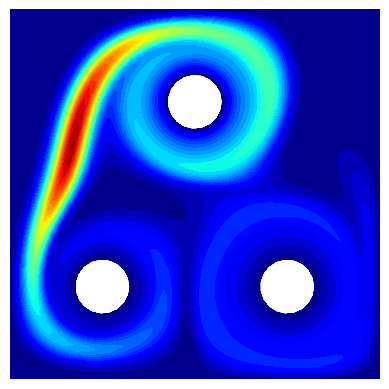

In [48]:
# TRAJECTORY EXAMPLE (PLOT)

trajectory(Y[-1])

In [12]:
# TRAIN-VALIDATION-TEST SPLITTING

ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

Ytrain = Y[idx_train]
Yvalid = Y[idx_valid]
Ytest = Y[idx_test]
MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]

# State reduction - POD

In [13]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from dlroms.roms import mre, mse, euclidean # Error metrics
from dlroms.ocp import L2 # Error metric

l2_state = L2(mesh, Yh, measure = dx, core = CPU)

mse = mse(euclidean)
mre = mre(euclidean)

In [14]:
# RESHAPE MATRICES

Ytrain = Ytrain.reshape(-1, nstate).numpy()
Yvalid = Yvalid.reshape(-1, nstate).numpy()
Ytest = Ytest.reshape(-1, nstate).numpy()

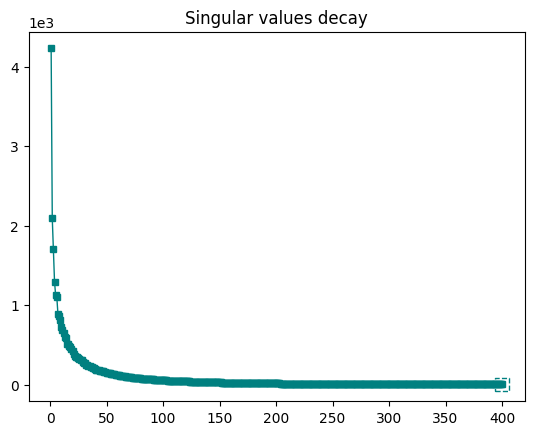

In [15]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Y

from sklearn.utils.extmath import randomized_svd

kstate = 400 # Number of POD modes

U, S, V = randomized_svd(Ytrain, n_components = kstate)

plt.plot([i for i in range(1, kstate + 1)], S, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.scatter(kstate, S[kstate-1], color = teal[14], marker = 's', facecolors = 'none', linestyle = '--', s = 100)
plt.title("Singular values decay");

Ytrain_POD = Ytrain @ V.transpose()
Yvalid_POD = Yvalid @ V.transpose()
Ytest_POD = Ytest @ V.transpose()
Ytrain_reconstructed = U @ np.diag(S) @ V
Yvalid_reconstructed = Yvalid @ V.transpose() @ V
Ytest_reconstructed = Ytest @ V.transpose() @ V

In [16]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("POD reconstruction errors:")
print("")
print("Mean relative error on Y: %s." % num2p(mre(torch.from_numpy(Ytest), torch.from_numpy(Ytest_reconstructed))))
print("L2 mean relative error on Y: %s." % num2p(l2_state.mre(torch.from_numpy(Ytest), torch.from_numpy(Ytest_reconstructed))))

POD reconstruction errors:

Mean relative error on Y: 0.46%.
L2 mean relative error on Y: 0.41%.


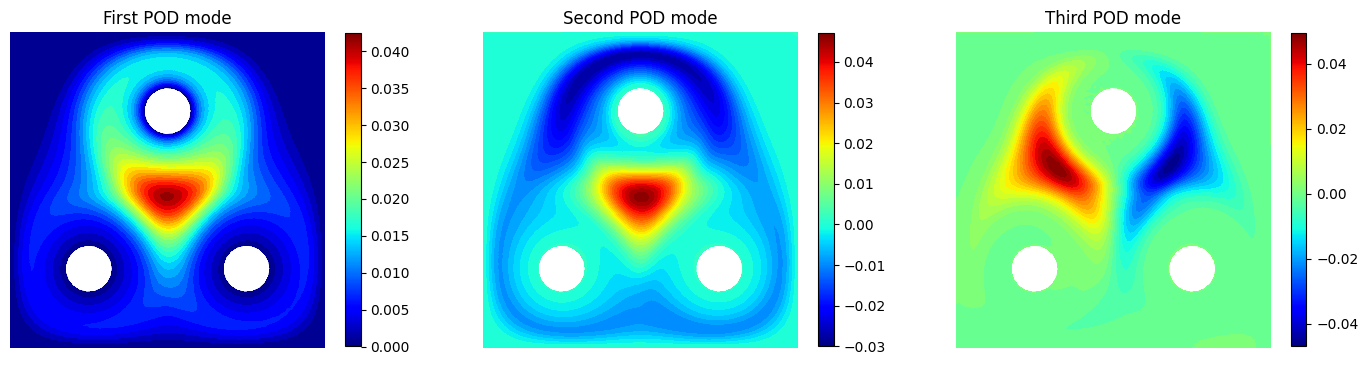

In [17]:
# POD MODES (PLOT)

plotlist = [V[0], V[1], V[2]]
fe.multiplot(plotlist, (10, 10), Yh, titles = ("First POD mode", "Second POD mode", "Third POD mode"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

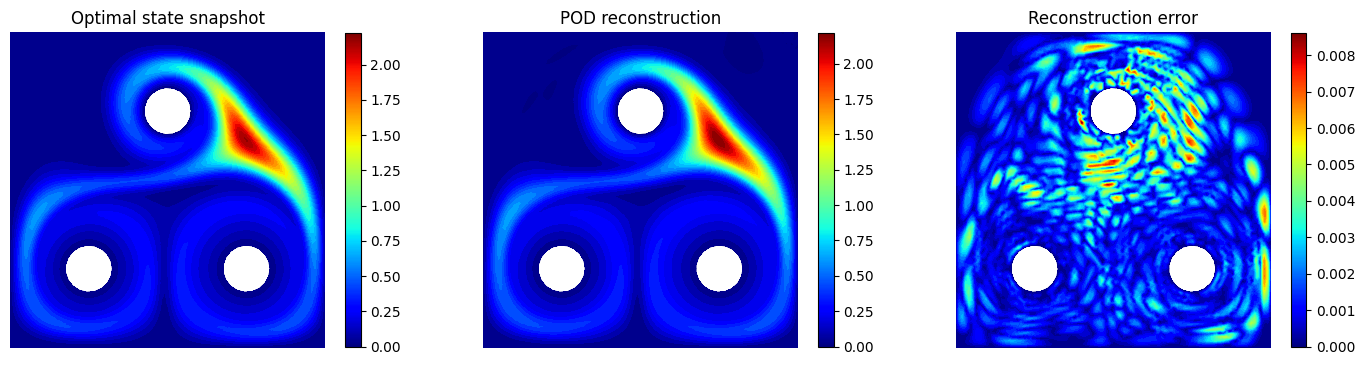

In [18]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plotlist = [Ytest[which], Ytest_reconstructed[which], np.sqrt((Ytest[which] - Ytest_reconstructed[which])**2)]
fe.multiplot(plotlist, (10, 10), Yh, titles = ("Optimal state snapshot", "POD reconstruction", "Reconstruction error"), size = 6, cmap = "jet", levelcurves = True, colorbar = True, vmin = 0)

In [19]:
# RESHAPE MATRICES

Ytrain = torch.from_numpy(Ytrain.reshape(ntrain, ntimes, nstate))
Yvalid = torch.from_numpy(Yvalid.reshape(nvalid, ntimes, nstate))
Ytest = torch.from_numpy(Ytest.reshape(ntest, ntimes, nstate))
Ytrain_POD = torch.from_numpy(Ytrain_POD.reshape(ntrain, ntimes, kstate))
Yvalid_POD = torch.from_numpy(Yvalid_POD.reshape(nvalid, ntimes, kstate))
Ytest_POD = torch.from_numpy(Ytest_POD.reshape(ntest, ntimes, kstate))

# SHRED

In [55]:
# EXTRACT SENSOR DATA

nsensors = 10
sensor_locations = np.random.choice(nstate, size = nsensors, replace = False)

sensor_data_train = Ytrain[:,:,sensor_locations]
sensor_data_valid = Yvalid[:,:,sensor_locations]
sensor_data_test = Ytest[:,:,sensor_locations]

In [66]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from processdata import Padding, TimeSeriesDataset

lag = ntimes

train_data_in = Padding(sensor_data_train, lag)
valid_data_in = Padding(sensor_data_valid, lag)
test_data_in = Padding(sensor_data_test, lag)

train_data_out = Padding(Ytrain_POD, 1).squeeze(1)
valid_data_out = Padding(Yvalid_POD, 1).squeeze(1)
test_data_out = Padding(Ytest_POD, 1).squeeze(1)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [67]:
# SHRED training

from models import SHRED, fit

shred = models.SHRED(nsensors, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout=0.1).to("cpu")
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 10)

		Train 	Valid
Epoch 98:	8.10%	12.95%


In [66]:
Ytrain_POD_hat = shred(train_data_in)
mre(Ytrain_POD_hat, train_data_out)

RuntimeError: The size of tensor a (2080) must match the size of tensor b (26) at non-singleton dimension 1

In [60]:
# AUTOENCODERS AND POLICY DEFINITIONS

from dlroms.dnns import Weightless

ny = 16 # State latent dimension
encoder_Y = Dense(ky, 100) + Dense(100, ny)
decoder_Y = Dense(ny, 100) + Dense(100, 100) + Dense(100, ky, activation = None)
autoencoder_Y = encoder_Y + decoder_Y

nu = 16 # Latent dimension
encoder_U = Dense(kux + kuy, 100) + Dense(100, nu)
decoder_U = Dense(nu, 100) + Dense(100, 100) + Dense(100, kux + kuy, activation = None)
autoencoder_U = encoder_U + decoder_U

class Embedd(Weightless): # First layer with some fixed transformation of the input (driven by the problem)
    def forward(self, x):
        return torch.cat([x, x[:,[-3]].cos(), x[:,[-3]].sin(), x[:,[-1]].cos(), x[:,[-1]].sin(), x[:,[-2]]*x[:,[-1]].cos(), x[:,[-2]]*x[:,[-1]].sin()], axis = 1)

policy = Embedd() + Dense(ny + nparams + 6, 50) + Dense(50, 50) + Dense(50, 50) + Dense(50, nu, activation = None)

In [ ]:
autoencoder_Y.unfreeze()
autoencoder_U.unfreeze()
policy.unfreeze()

Y0_POD_reconstructed, U_POD_reconstructed, U_POD_hat = ocp.latent_policy(Y0_POD, U_POD, MU, encoder_Y, decoder_Y, encoder_U, decoder_U, policy, training = True, initialization = False, save = False, path = 'NN/OptimalTransportFluid/', epochs = 1000, weights = [0.0001, 0.0001, 0.001], optim = torch.optim.LBFGS, loss = mse, error = mre, best = False)

Epoch 908
			Train	Test
Reduction(State) 	4.85%	5.80%.
Reduction(Control) 	5.37%	5.57%.
Policy 			2.24%	4.55%.
Policy(Decoding) 	5.65%	10.00%.


In [35]:
# POD+AE RECONSTRUCTION ERRORS ON TEST DATA

Y0_reconstructed = projectup(pod_Y, Y0_POD_reconstructed)
Ux_reconstructed = projectup(pod_Ux, U_POD_reconstructed[:,:kux])
Uy_reconstructed = projectup(pod_Uy, U_POD_reconstructed[:,kux:])
U_reconstructed = merge_U(Ux_reconstructed, Uy_reconstructed)

print("POD+AE state reconstruction errors:")
print("")
print("Mean relative error on Y: %s." % num2p(mre(Y0[ntrain:], Y0_reconstructed[ntrain:])))
print("L2 mean relative error on Y: %s." % num2p(l2_state.mre(Y0[ntrain:], Y0_reconstructed[ntrain:])))
print("")
print("POD+AE control reconstruction errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_reconstructed[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_reconstructed[ntrain:], Uy[ntrain:], Uy_reconstructed[ntrain:])))

POD+AE state reconstruction errors:

Mean relative error on Y: 5.75%.
L2 mean relative error on Y: 5.64%.

POD+AE control reconstruction errors:

Mean relative error on U: 5.89%.
L2 mean relative error on U: 5.86%.


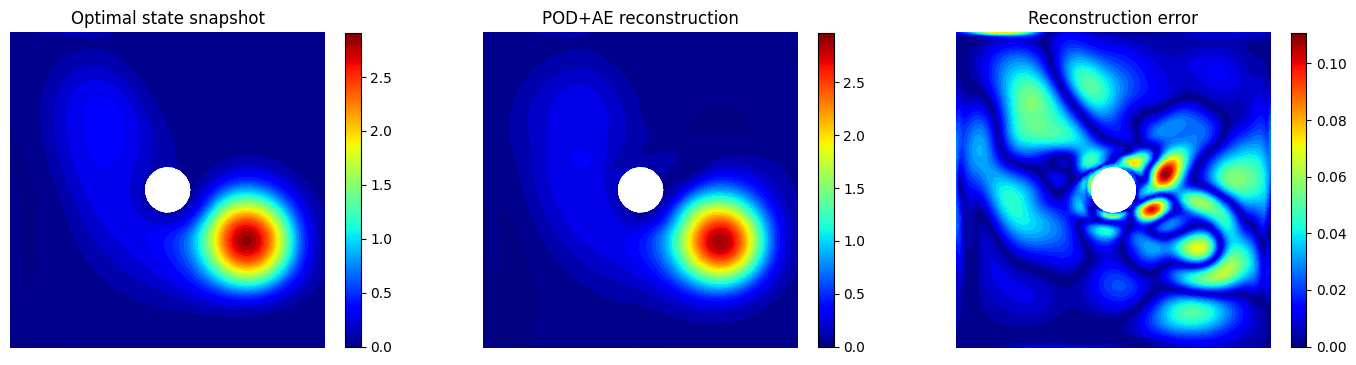

In [36]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

plotlist = [Y0[which], Y0_reconstructed[which], ((Y0[which] - Y0_reconstructed[which])**2).sqrt()]
fe.multiplot(plotlist, (10, 10), Yh, titles = ("Optimal state snapshot", "POD+AE reconstruction", "Reconstruction error"), size = 6, cmap = "jet", levelcurves = True, colorbar = True, vmin = 0)

Text(0.5, 1.0, 'Reconstruction error')

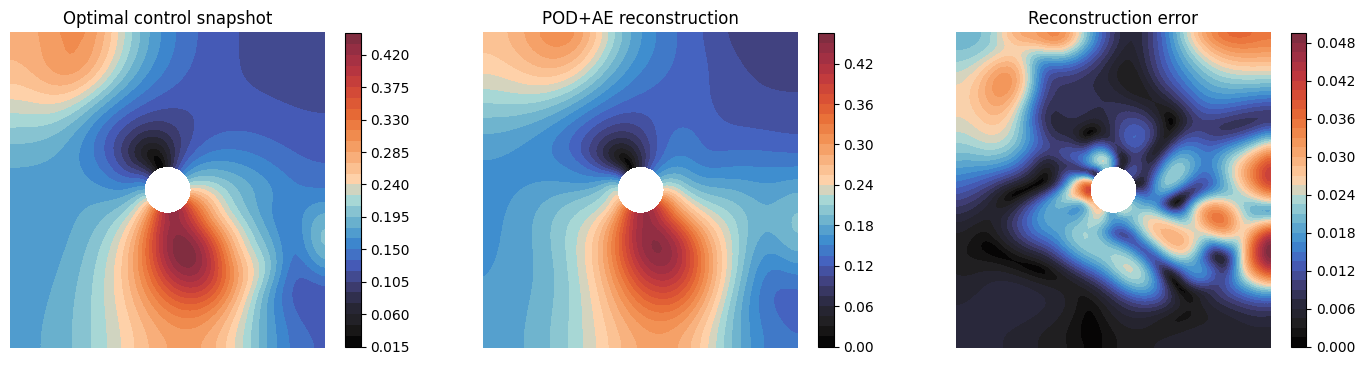

In [39]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -3

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Optimal control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_reconstructed[which], shrink = 0.8)
plt.title("POD+AE reconstruction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_reconstructed[which])**2).sqrt(), shrink = 0.8)
plt.title("Reconstruction error")

In [40]:
# POLICY ERROR ON TEST DATA

Ux_hat = projectup(pod_Ux, U_POD_hat[:,:kux])
Uy_hat = projectup(pod_Uy, U_POD_hat[:,kux:])
U_hat = merge_U(Ux_hat, Uy_hat)

print("Policy interpolation errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_hat[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux[ntrain:], Ux_hat[ntrain:], Uy[ntrain:], Uy_hat[ntrain:])))

Policy interpolation errors:

Mean relative error on U: 9.74%.
L2 mean relative error on U: 9.72%.


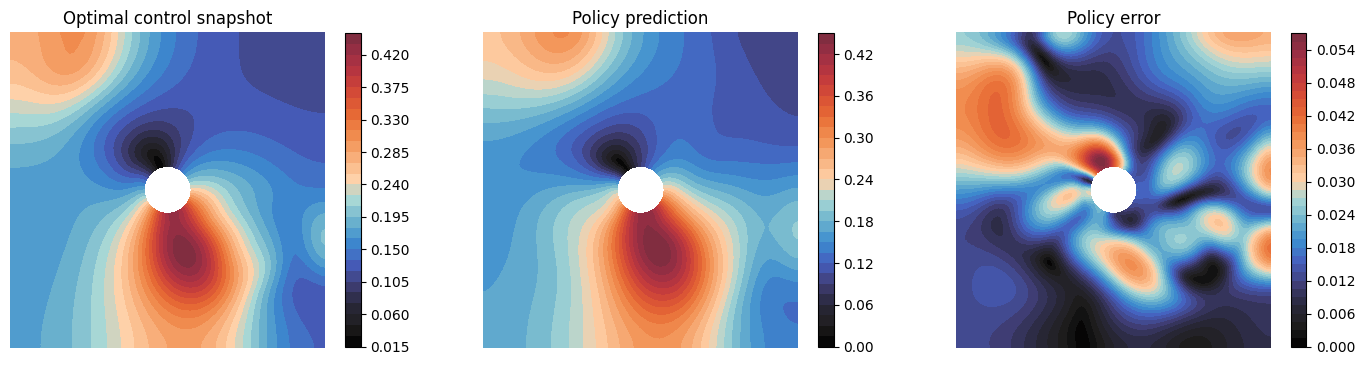

In [43]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -3

plt.figure(figsize = (60, 60))

plt.subplot(10, 10, 1)
plot_u(U[which], shrink = 0.8)
plt.title("Optimal control snapshot")

plt.subplot(10, 10, 2)
plot_u(U_hat[which], shrink = 0.8)
plt.title("Policy prediction")

plt.subplot(10, 10, 3)
plot_u(((U[which] - U_hat[which])**2).sqrt(), shrink = 0.8)
plt.title("Policy error");

# Test case: real-time optimal transport related to a new starting position and a new target destination

In [53]:
# DEFINE INITIAL STATE AND SCENARIO PARAMETERS FOR TESTING

y0_params_test = [0] * len(y0_ranges)
for i in range(len(y0_ranges)):
    y0_params_test[i] = ((y0_ranges[i][1] - y0_ranges[i][0]) * CPU.rand() + y0_ranges[i][0]).item()  
y0_test = gaussian_generator(y0_params_test)

yd_params_test = [0] * len(yd_ranges)
for i in range(len(yd_ranges)):
    yd_params_test[i] = ((yd_ranges[i][1] - yd_ranges[i][0]) * CPU.rand() + yd_ranges[i][0]).item()  

v_in_params_test = [0] * len(v_in_ranges)
for i in range(len(v_in_ranges)):
    v_in_params_test[i] = ((v_in_ranges[i][1] - v_in_ranges[i][0]) * CPU.rand() + v_in_ranges[i][0]).item()  

MU_test = CPU.tensor([yd_params_test[1], v_in_params_test[0], v_in_params_test[1]]).unsqueeze(0)

In [54]:
# COMPUTE THE Fluid VELOCITY FIELD

v = compute_velocity(v_in_params_test)

In [55]:
# OPTIMAL TRAJECTORY PREDICTED BY THE POLICY

Y0_test = CPU.zeros(ntimesteps + 1, nstate)
Y0_test[0] = CPU.tensor(y0_test.vector())
U_hat_test = CPU.zeros(ntimesteps, ncontrol)

for i in range(ntimesteps):
    Y0_DLROM_test = encoder_Y(projectdown(pod_Y, Y0_test[i].unsqueeze(0)).squeeze(2))
    U_DLROM_hat_test = policy(torch.cat((Y0_DLROM_test, MU_test), 1))
    Ux_hat_test = projectup(pod_Ux, decoder_U(U_DLROM_hat_test)[:,:kux])
    Uy_hat_test = projectup(pod_Uy, decoder_U(U_DLROM_hat_test)[:,kux:])
    U_hat_test[i] = merge_U(Ux_hat_test, Uy_hat_test)

    ut = [fe.asvector(U_hat_test[i], Uh)]
    
    yt, J = compute_state(ut, v, fe.asvector(Y0_test[i], Yh), dt, 1)
    clc()

    Y0_test[i+1] = yt[-1]

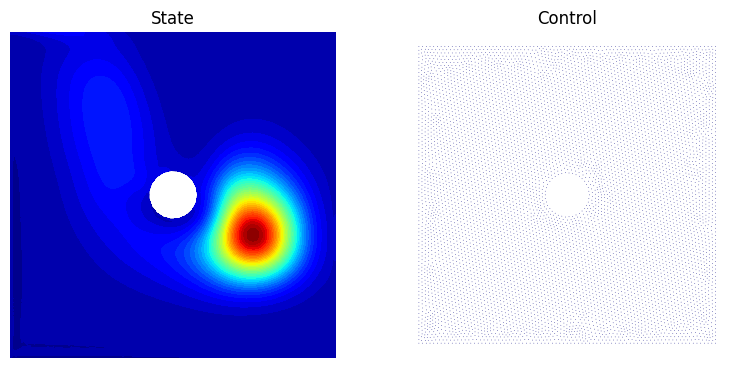

In [59]:
# OPTIMAL TEST TRAJECTORY (PLOT)

plot_trajectory(Y0_test, U_hat_test)